___

In [1]:
from IPython.display import clear_output
from tqdm import tqdm
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

def get_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data[['Open', 'High', 'Low', 'Close', 'Volume']]

def make_generator_model(noise_dim, sequence_length, num_features):
    model = keras.Sequential([
        keras.layers.Dense(128 * sequence_length, input_shape=(noise_dim,), dtype=tf.float32),
        keras.layers.Reshape((sequence_length, 128)),
        keras.layers.Conv1D(64, kernel_size=3, padding='same', dtype=tf.float32),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Conv1D(32, kernel_size=3, padding='same', dtype=tf.float32),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Conv1D(num_features, kernel_size=3, padding='same', activation='tanh', dtype=tf.float32)
    ])
    return model

def make_critic_model(sequence_length, num_features):
    model = keras.Sequential([
        keras.layers.Conv1D(32, kernel_size=3, padding='same', input_shape=(sequence_length, num_features), dtype=tf.float32),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Conv1D(64, kernel_size=3, padding='same', dtype=tf.float32),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Conv1D(128, kernel_size=3, padding='same', dtype=tf.float32),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Flatten(),
        keras.layers.Dense(1, dtype=tf.float32)
    ])
    return model

class WGAN:
    def __init__(self, generator, critic, noise_dim, critic_extra_steps=5, gp_weight=10.0): # Try values between 15 and 25
        self.generator = generator
        self.critic = critic
        self.noise_dim = noise_dim
        self.critic_extra_steps = critic_extra_steps
        self.gp_weight = gp_weight

        # self.g_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9) # ORIGINAL
        # self.c_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9) # ORIGINAL
        self.c_optimizer = tf.keras.optimizers.Adam(keras.optimizers.schedules.ExponentialDecay(
                                                    initial_learning_rate=0.00005,
                                                    decay_steps=1000,
                                                    decay_rate=0.9
                                                    ), beta_1=0.5, beta_2=0.9)
        # self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
        self.g_optimizer = tf.keras.optimizers.Adam(keras.optimizers.schedules.ExponentialDecay(
                                                    initial_learning_rate=0.00005,
                                                    decay_steps=1000,
                                                    decay_rate=0.9
                                                    ), beta_1=0.5, beta_2=0.9)
    def gradient_penalty(self, real, fake):
        alpha = tf.random.uniform([real.shape[0], 1, 1], 0.0, 1.0, dtype=tf.float32)
        diff = fake - real
        interpolated = real + alpha * diff
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)
        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    @tf.function
    def train_step(self, real_data):
        real_data = tf.cast(real_data, tf.float32)  # ensuring real_data is float32
        batch_size = tf.shape(real_data)[0]
        for _ in range(self.critic_extra_steps):
            noise = tf.random.normal([batch_size, self.noise_dim], dtype=tf.float32)
            with tf.GradientTape() as tape:
                fake_data = self.generator(noise, training=True)
                critic_real = self.critic(real_data, training=True)
                critic_fake = self.critic(fake_data, training=True)
                critic_loss = tf.reduce_mean(critic_fake) - tf.reduce_mean(critic_real)
                gp = self.gradient_penalty(real_data, fake_data)
                critic_loss += self.gp_weight * gp
            critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(critic_grad, self.critic.trainable_variables))

        noise = tf.random.normal([batch_size, self.noise_dim], dtype=tf.float32)
        with tf.GradientTape() as tape:
            fake_data = self.generator(noise, training=True)
            critic_fake = self.critic(fake_data, training=True)
            generator_loss = -tf.reduce_mean(critic_fake)
        generator_grad = tape.gradient(generator_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(generator_grad, self.generator.trainable_variables))

        return {"critic_loss": critic_loss, "generator_loss": generator_loss}

def plot_loss(G_loss, D_loss):
    plt.figure(figsize=(6, 4))
    plt.title('Development of Training Losses During Training')
    plt.plot(D_loss, label='Critic Loss')
    plt.plot(G_loss, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None

    def __call__(self, g_loss, c_loss):
        current_loss = g_loss + c_loss  # Simple sum for losses in early callback. Naive implementation 
        if self.best_loss is None:
            self.best_loss = current_loss
            return False

        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
        
def train(wgan, dataset, epochs, patience=100):
    G_loss = []
    D_loss = []
    early_stopping = EarlyStopping(patience=patience)
    
    for epoch in range(epochs):
        G_list = []
        D_list = []

        for batch in dataset:
            losses = wgan.train_step(batch)
            G_list.append(losses['generator_loss'].numpy())
            D_list.append(losses['critic_loss'].numpy())

        epoch_g_loss = np.mean(G_list)
        epoch_d_loss = np.mean(D_list)
        G_loss.append(epoch_g_loss)
        D_loss.append(epoch_d_loss)

        clear_output(wait=True)
        plot_loss(G_loss, D_loss)
        
        print(f'Epoch {epoch + 1}, Critic Loss: {epoch_d_loss:.4f}, Generator Loss: {epoch_g_loss:.4f}')

        if early_stopping(epoch_g_loss, epoch_d_loss):
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    return G_loss, D_loss

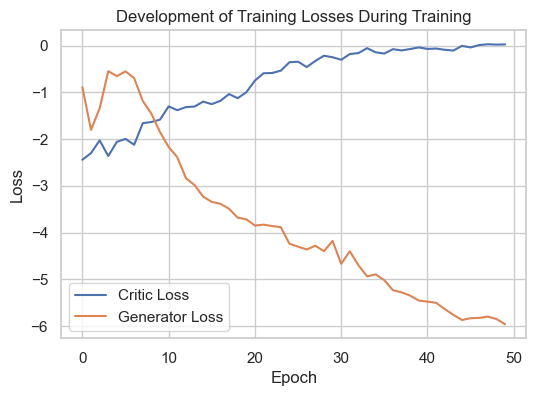

Epoch 50, Critic Loss: 0.0234, Generator Loss: -5.9627


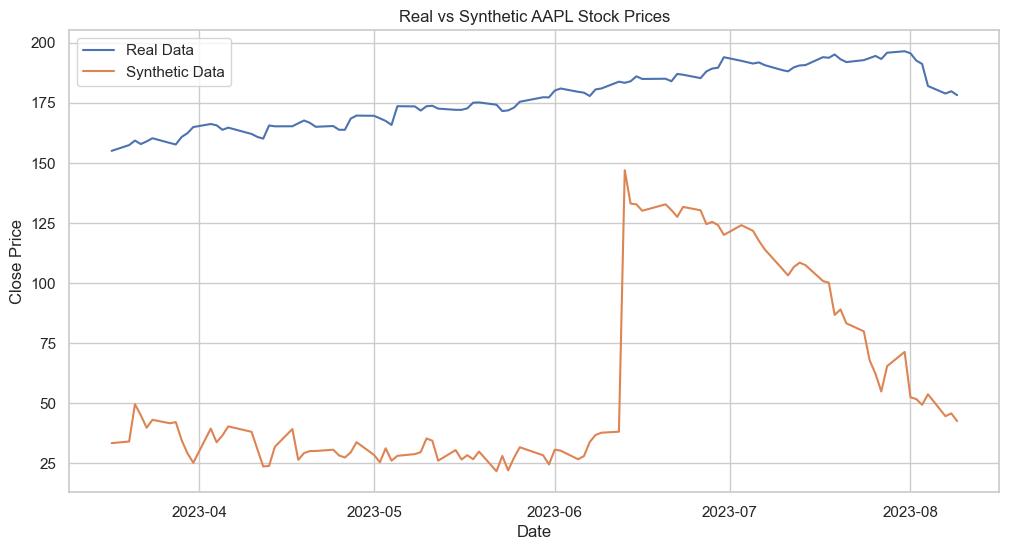

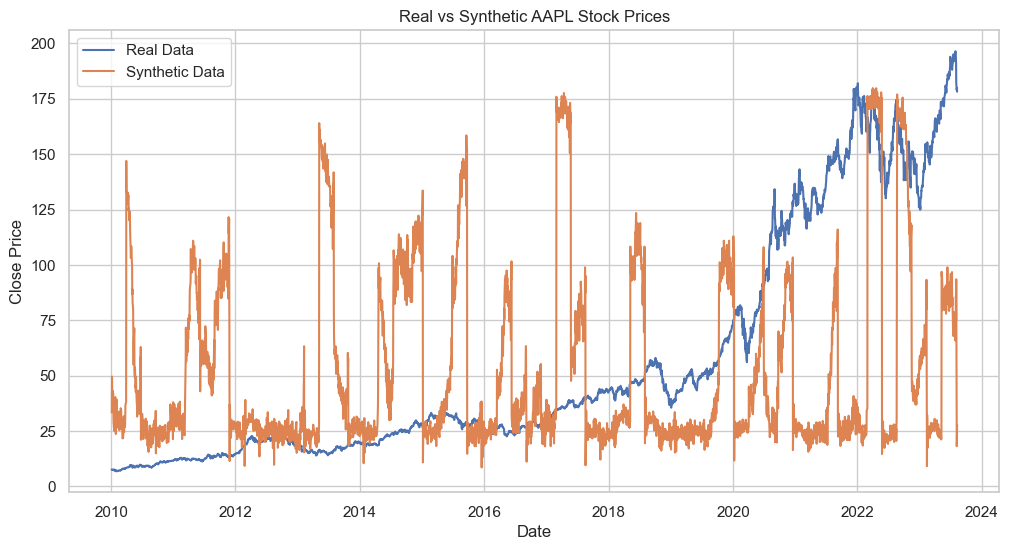

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

def get_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data[['Open', 'High', 'Low', 'Close', 'Volume']]

start_date = '2010-01-01'
end_date = '2023-08-10'  
aapl_data = get_stock_data('AAPL', start_date, end_date)

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(aapl_data)

sequence_length = 60  
num_features = normalized_data.shape[1]

def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
    return np.array(sequences)

sequences = create_sequences(normalized_data, sequence_length)

batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(sequences).shuffle(1000).batch(batch_size)

noise_dim = 100
generator = make_generator_model(noise_dim, sequence_length, num_features)
critic = make_critic_model(sequence_length, num_features)

wgan = WGAN(generator, critic, noise_dim)
epochs = 50  

train(wgan, dataset, epochs)

def generate_synthetic_data(generator, noise_dim, num_samples):
    noise = tf.random.normal([num_samples, noise_dim])
    generated_data = generator(noise, training=False)
    return generated_data.numpy()

num_samples = 100
synthetic_data = generate_synthetic_data(wgan.generator, noise_dim, num_samples)

synthetic_data_original_scale = scaler.inverse_transform(synthetic_data.reshape(-1, num_features))

plt.figure(figsize=(12, 6))
plt.plot(aapl_data.index[-100:], aapl_data['Close'].values[-100:], label='Real Data')
plt.plot(aapl_data.index[-100:], synthetic_data_original_scale[:100, 3], label='Synthetic Data')
plt.legend()
plt.title('Real vs Synthetic AAPL Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

samples = aapl_data.shape[0]

plt.figure(figsize=(12, 6))
plt.plot(aapl_data.index[-samples:], aapl_data['Close'].values[-samples:], label='Real Data')
plt.plot(aapl_data.index[-samples:], synthetic_data_original_scale[:samples, 3], label='Synthetic Data')
plt.legend()
plt.title('Real vs Synthetic AAPL Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()